In [91]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches, get_exact_matches_indices
from IPython.display import display



In [92]:
USE_GPU = True
TRAIN = True

In [93]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1726514861.839594    4284 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726514861.841035    4284 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726514861.842163    4284 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726514861.843786    4284 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [94]:
IMAGE_SIZE = 14
CHANNELS = 1
BATCH_SIZE = 32
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
LEARNING_RATE = 0.001
EPOCHS = 70
CRITIC_STEPS = 4
GP_WEIGHT = 9.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
NUM_LANGS = 100

In [95]:
data = np.load("./data/language_parameters.npz", allow_pickle=True)
language_parameters = data["language_parameters"]
languages = data["languages"]
parameters = data["parameters"]

l = language_parameters.shape[0]

X = np.hstack([language_parameters.copy(), np.zeros((l, 8))]).reshape(l, IMAGE_SIZE, IMAGE_SIZE)
X = np.expand_dims(X, axis=3)

MAX_VALUE = X.max()

X /= MAX_VALUE

assert language_parameters.shape[0] == languages.shape[0]

language_parameters.shape, languages.shape, parameters.shape, X.shape, Z_DIM

((1021, 188), (1021, 2), (188, 2), (1021, 14, 14, 1), 196)

In [96]:
critic = Sequential(
    [
        Input(shape=X.shape[1:]),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * IMAGE_SIZE, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 7, 7, 14)       │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_60 (LeakyReLU)      │ (None, 7, 7, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 4, 4, 28)       │         3,556 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_61 (LeakyReLU)      │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 2, 2, 56)       │        14,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_62 (LeakyReLU)      │ (None, 2, 2, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 2, 2, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 1, 1, 112)      │        56,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_63 (LeakyReLU)      │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 1, 1, 196)      │        88,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_64 (LeakyReLU)      │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 196)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,428 (634.48 KB)

 Trainable params: 162,428 (634.48 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * IMAGE_SIZE, kernel_size=4, strides=2, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=4, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * IMAGE_SIZE, kernel_size=8, strides=1, padding="same", activation="sigmoid"
        ),
        layers.Reshape(X.shape[1:]),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_12 (Reshape)            │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_30             │ (None, 4, 4, 196)      │       614,656 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 4, 4, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 2, 2, 112)      │       351,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 2, 2, 112)      │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_65 (LeakyReLU)      │ (None, 2, 2, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 2, 2, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 1, 1, 56)       │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 1, 1, 56)       │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_66 (LeakyReLU)      │ (None, 1, 1, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ (None, 2, 2, 28)       │        25,088 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_67 (LeakyReLU)      │ (None, 2, 2, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_32             │ (None, 4, 4, 28)       │         3,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 2, 2, 28)       │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 2, 2, 28)       │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_68 (LeakyReLU)      │ (None, 2, 2, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_33             │ (None, 4, 4, 28)       │         3,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 1, 1, 56)       │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 1, 1, 56)       │           224 │
│ (BatchNormalization)            │                        │             

 Total params: 1,810,676 (6.91 MB)

 Trainable params: 1,810,172 (6.91 MB)

 Non-trainable params: 504 (1.97 KB)

In [98]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [99]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [100]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, latent_dim, num_img=10, display_on_epoch=10, figsize=(28, 28)):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.display_on_epoch = display_on_epoch
        self.figsize = figsize

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.display_on_epoch == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors).numpy()
            plt.figure(figsize=self.figsize)

            for i in range(self.num_img):
                _ = plt.subplot(1, self.num_img, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

Epoch 1/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - c_gp: 0.0487 - c_loss: 0.4493 - c_wass_loss: 0.0114 - g_loss: -0.0151  

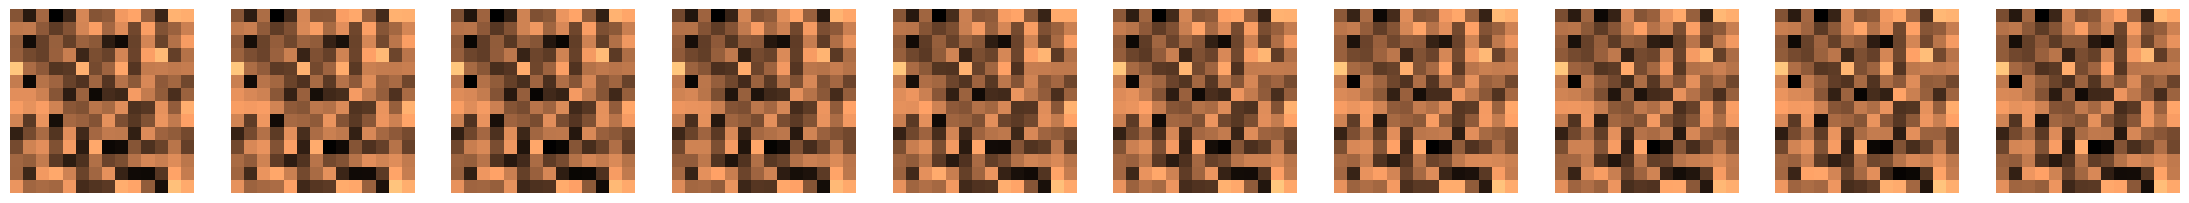

3/3 ━━━━━━━━━━━━━━━━━━━━ 62s 13s/step - c_gp: 0.0484 - c_loss: 0.4466 - c_wass_loss: 0.0111 - g_loss: -0.0147
Epoch 2/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0381 - c_loss: 0.3457 - c_wass_loss: 0.0031 - g_loss: -0.0091
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - c_gp: 0.0278 - c_loss: 0.2500 - c_wass_loss: -1.2927e-04 - g_loss: -0.0081
Epoch 6/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 7/70


/home/pappa/anaconda3/envs/conlanger/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - c_gp: 0.0267 - c_loss: 0.2381 - c_wass_loss: -0.0020 - g_loss: -0.0087
Epoch 8/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 9/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0244 - c_loss: 0.2156 - c_wass_loss: -0.0044 - g_loss: -0.0085
Epoch 10/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 11/70
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - c_gp: 0.0291 - c_loss: 0.2562 - c_wass_loss: -0.0061 - g_loss: -0.0094

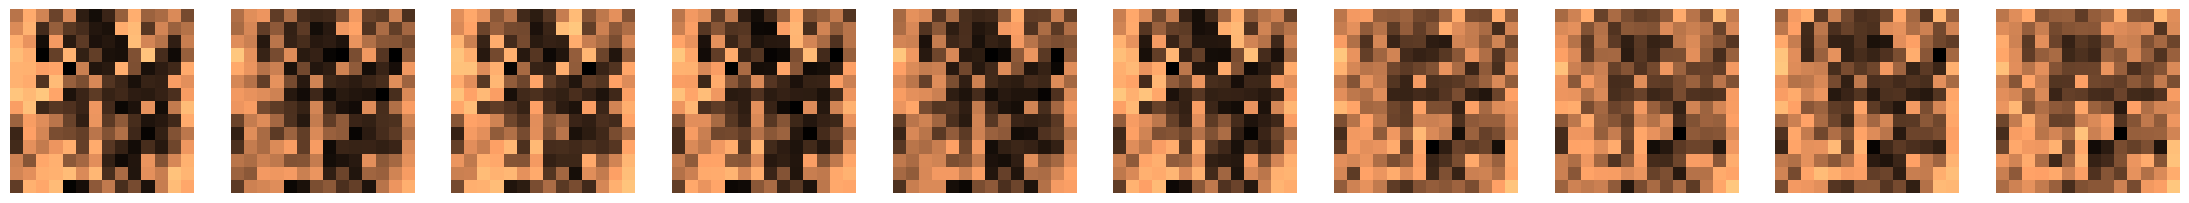

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - c_gp: 0.0272 - c_loss: 0.2384 - c_wass_loss: -0.0062 - g_loss: -0.0097
Epoch 12/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 13/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - c_gp: 0.0246 - c_loss: 0.2149 - c_wass_loss: -0.0066 - g_loss: -0.0115
Epoch 14/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 15/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - c_gp: 0.0208 - c_loss: 0.1807 - c_wass_loss: -0.0066 - g_loss: -0.0138
Epoch 16/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 17/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0224 - c_loss: 0.1945 - c_wass_loss: -0.0067 - g_loss: -0.0172
Epoch 18/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 

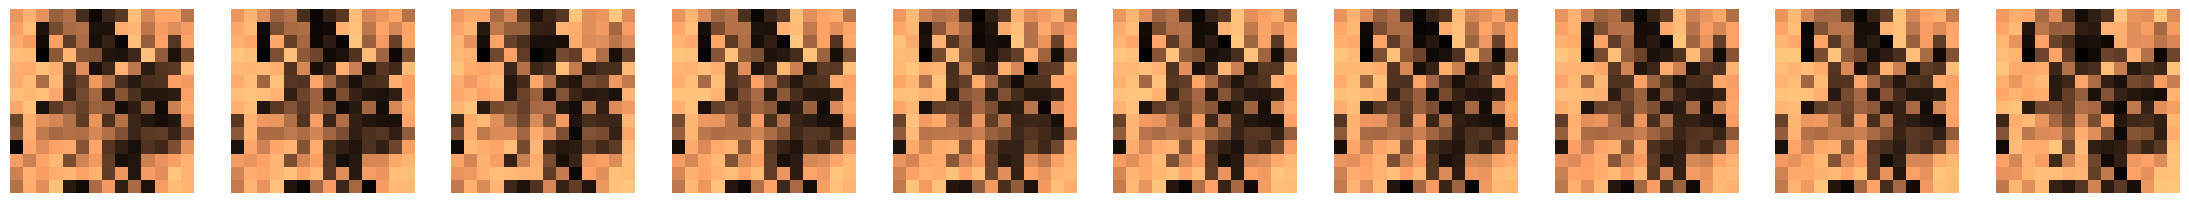

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step - c_gp: 0.0181 - c_loss: 0.1551 - c_wass_loss: -0.0079 - g_loss: -0.0218
Epoch 22/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 23/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0166 - c_loss: 0.1421 - c_wass_loss: -0.0075 - g_loss: -0.0241
Epoch 24/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 25/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0169 - c_loss: 0.1438 - c_wass_loss: -0.0085 - g_loss: -0.0267
Epoch 26/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 27/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - c_gp: 0.0167 - c_loss: 0.1426 - c_wass_loss: -0.0075 - g_loss: -0.0294
Epoch 28/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e

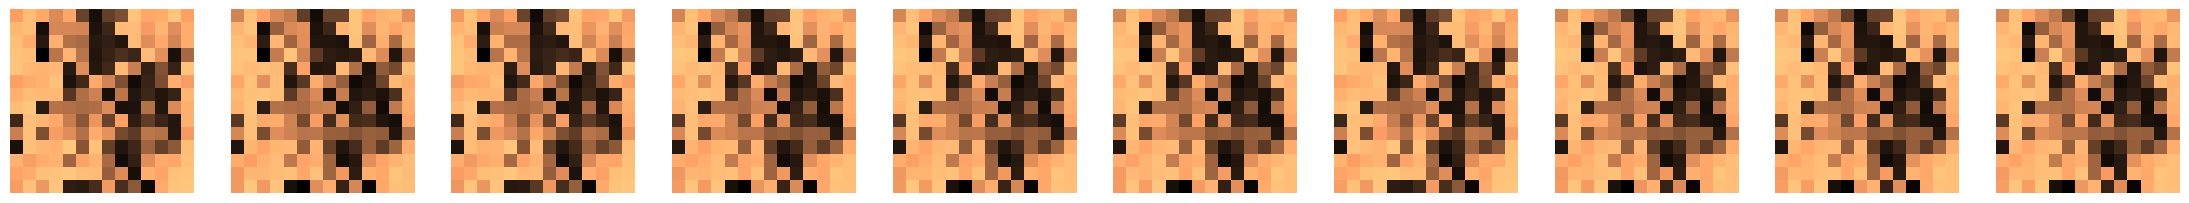

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - c_gp: 0.0164 - c_loss: 0.1390 - c_wass_loss: -0.0082 - g_loss: -0.0337
Epoch 32/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 33/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0157 - c_loss: 0.1315 - c_wass_loss: -0.0096 - g_loss: -0.0347
Epoch 34/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 35/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0135 - c_loss: 0.1119 - c_wass_loss: -0.0095 - g_loss: -0.0363
Epoch 36/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 37/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0150 - c_loss: 0.1258 - c_wass_loss: -0.0093 - g_loss: -0.0384
Epoch 38/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000

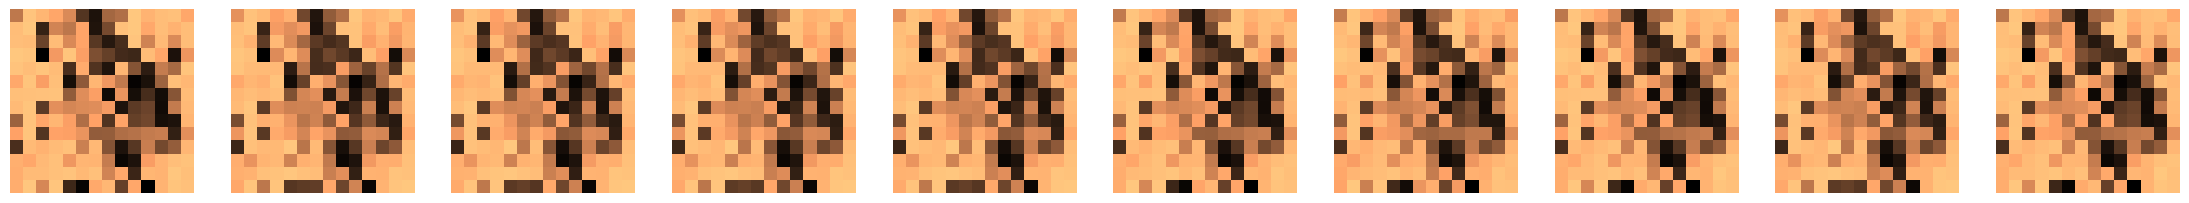

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - c_gp: 0.0152 - c_loss: 0.1282 - c_wass_loss: -0.0087 - g_loss: -0.0415
Epoch 42/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 43/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0138 - c_loss: 0.1146 - c_wass_loss: -0.0098 - g_loss: -0.0428
Epoch 44/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 45/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0134 - c_loss: 0.1120 - c_wass_loss: -0.0088 - g_loss: -0.0468
Epoch 46/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 47/70
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0102 - c_loss: 0.0835 - c_wass_loss: -0.0085 - g_loss: -0.0476

2024-09-16 20:28:47.977963: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0118 - c_loss: 0.0971 - c_wass_loss: -0.0092 - g_loss: -0.0482
Epoch 48/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 49/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - c_gp: 0.0142 - c_loss: 0.1196 - c_wass_loss: -0.0086 - g_loss: -0.0502
Epoch 50/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 51/70
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - c_gp: 0.0110 - c_loss: 0.0920 - c_wass_loss: -0.0073 - g_loss: -0.0514

2024-09-16 20:28:48.292439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18011973223908516074


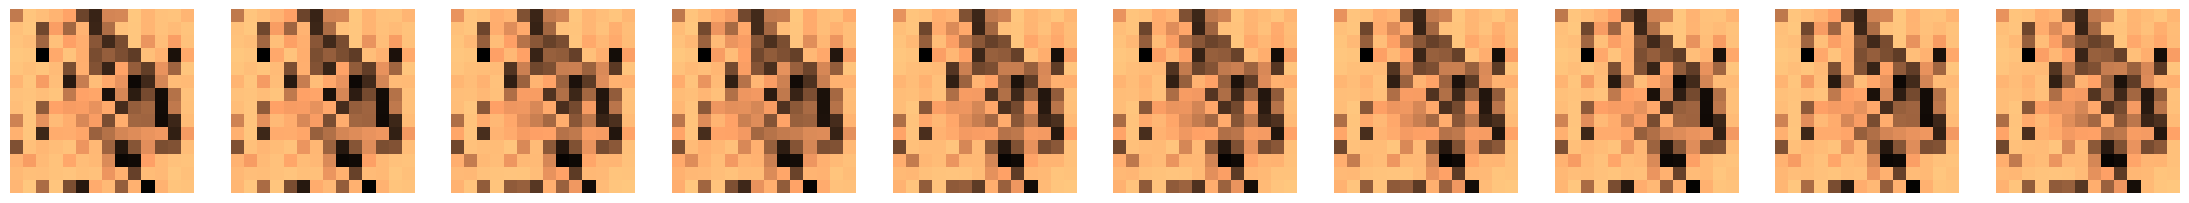

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - c_gp: 0.0113 - c_loss: 0.0942 - c_wass_loss: -0.0076 - g_loss: -0.0516
Epoch 52/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 53/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0131 - c_loss: 0.1098 - c_wass_loss: -0.0080 - g_loss: -0.0528
Epoch 54/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 55/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0123 - c_loss: 0.1035 - c_wass_loss: -0.0071 - g_loss: -0.0544
Epoch 56/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 57/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0119 - c_loss: 0.0989 - c_wass_loss: -0.0080 - g_loss: -0.0564
Epoch 58/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000

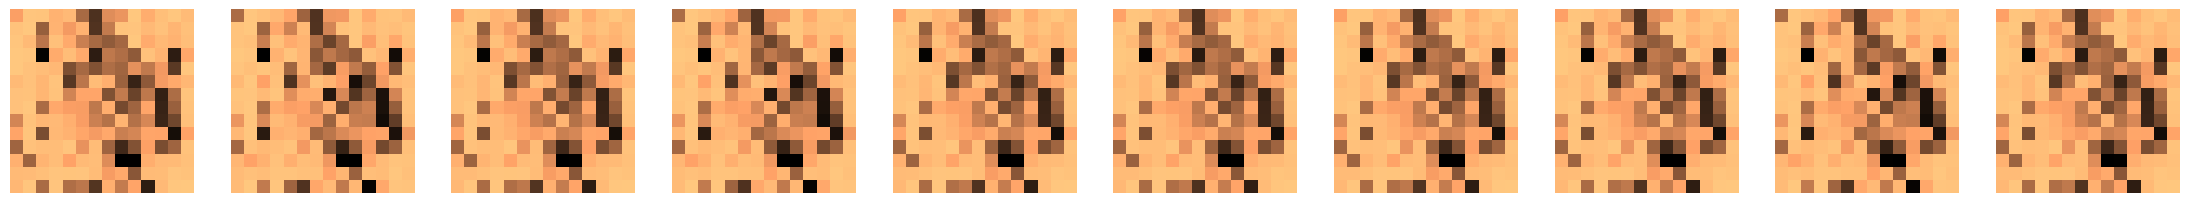

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - c_gp: 0.0109 - c_loss: 0.0922 - c_wass_loss: -0.0062 - g_loss: -0.0586
Epoch 62/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 63/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - c_gp: 0.0104 - c_loss: 0.0868 - c_wass_loss: -0.0068 - g_loss: -0.0591
Epoch 64/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 65/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - c_gp: 0.0109 - c_loss: 0.0916 - c_wass_loss: -0.0062 - g_loss: -0.0602
Epoch 66/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 67/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - c_gp: 0.0102 - c_loss: 0.0852 - c_wass_loss: -0.0062 - g_loss: -0.0607
Epoch 68/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+

In [101]:
if TRAIN:
    wgangp.fit(
        X,
        epochs=EPOCHS,
        steps_per_epoch=3,
        callbacks=[
            ImageGenerator(latent_dim=Z_DIM),
        ],
    )

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


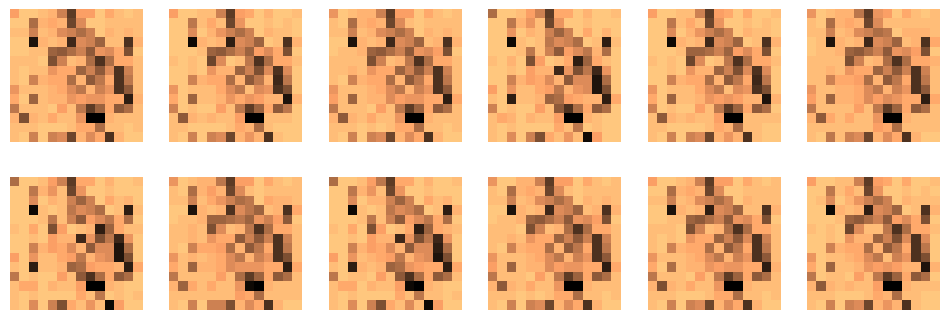

In [102]:
if TRAIN:
    
    noise = np.random.normal(size=(NUM_LANGS, Z_DIM))
    generated_language_parameters = generator.predict(noise)
    l = generated_language_parameters.shape[0]

    # normalise
    generated_language_parameters = (generated_language_parameters-np.min(generated_language_parameters))/(np.max(generated_language_parameters)-np.min(generated_language_parameters))

    # weirdness
    mean_lang = np.mean(X, axis=0).reshape(-1)
    diff_from_mean = np.array([np.mean(np.abs(mean_lang - g)) for g in generated_language_parameters])
    weirdness = np.round((diff_from_mean-np.min(diff_from_mean))/(np.max(diff_from_mean)-np.min(diff_from_mean)), decimals=2)

    np.savez_compressed(
        "./data/generated_language_parameters.npz",
        generated_language_parameters=generated_language_parameters,
        weirdness=weirdness
    )

else:
    data = np.load("./data/generated_language_parameters.npz", allow_pickle=True)
    generated_language_parameters = data["generated_language_parameters"]
    weirdness = data["weirdness"]
    l = generated_language_parameters.shape[0]

generated = (generated_language_parameters * MAX_VALUE).astype(int)

display_rows(generated, cmap="copper_r", r=2, c=6, size=(12, 4))

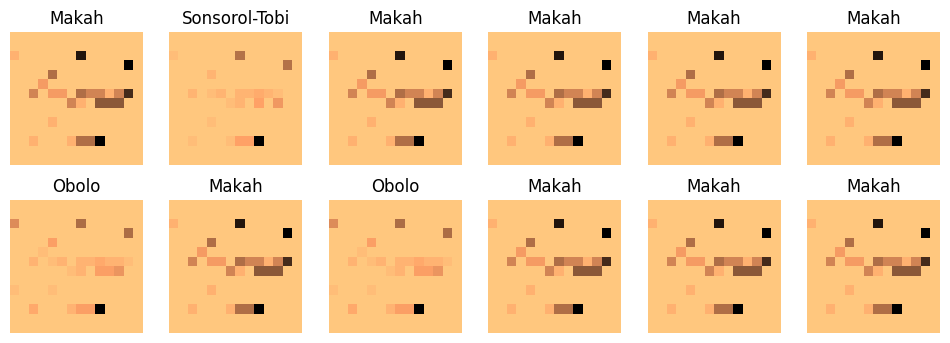

3.8286224489795915

In [103]:
# find closest matches
origin = (X * MAX_VALUE).astype(int)

closest_idx, closest, closest_diff = get_closest_matches(origin, generated, n=NUM_LANGS)
closest_language_names = np.take(languages[:, 1], closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=2, c=6, size=(12, 4))

np.mean(closest_diff)

In [104]:
# find exact matches

exact_idx = get_exact_matches_indices(origin, generated)
exact = np.take(X, exact_idx)
exact_language_names = np.take(languages[:, 1], exact_idx)

if len(exact_idx) > 0:
    display_rows(exact, titles=exact_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))
else:
    print("No exact matches. Noice!")

origin.shape, exact_idx.shape

No exact matches. Noice!


((1021, 14, 14, 1), (0,))

In [105]:
from cldfbench import get_dataset

wals = get_dataset("wals").cldf_reader()

param_df = (
    pd.DataFrame(wals.iter_rows("ParameterTable"))
    .set_index(["Area", "Chapter"])
    .drop(columns=["Description", "Contributor_ID"])
)

param_df = param_df[
    ~param_df.index.get_level_values("Area").isin(["Sign Languages", "Other"])
]

param_df.head(5)

ID  \
Area      Chapter                                   
Phonology Consonant Inventories                1A   
          Vowel Quality Inventories            2A   
          Consonant-Vowel Ratio                3A   
          Voicing in Plosives and Fricatives   4A   
          Voicing and Gaps in Plosive Systems  5A   

                                                                              Name  
Area      Chapter                                                                   
Phonology Consonant Inventories                              Consonant Inventories  
          Vowel Quality Inventories                      Vowel Quality Inventories  
          Consonant-Vowel Ratio                              Consonant-Vowel Ratio  
          Voicing in Plosives and Fricatives    Voicing in Plosives and Fricatives  
          Voicing and Gaps in Plosive Systems  Voicing and Gaps in Plosive Systems